In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import parse_ats # from $ATS_SRC_DIR/tools/utils/
import mass_balance 
mass_balance.MassBalanceFromVis.set_names_dev()


This is a notebook demonstrating how mass balance calculations are
best done for ATS simulations.

Note that all of these are approximate, and should not expect to
perfectly conserve mass.  The reason for this is that ATS will be
simulating at a higher time resolution than your vis, and therefore
the integrals implied here are not exact.  Similarly, to get an even
reasonable approximation, make sure that, for the time period you are
interested in, you use vis that is on the same or higher resolution
than your forcing data.

Author: Ethan Coon (coonet@ornl.gov)

## Surface Mass Balance

The surface mass balance is given by a balance of precipitation,
infiltration, runoff, and evaporation:

```d Theta / dt = P*n*A - I - R - E*n*A```

where:

* ```Theta``` is ```surface-water_content [mol]```,
* ```P``` is ```surface-precipitation_rain``` plus ```surface-precipitation_snow [m/s]```,
* ```I``` is infiltration, the negative of ```surface-surface_subsurface_flux [mol/s]```
* ```R``` runoff ```[mol/s]```,
* ```E``` evaporation (which is actually evaporation - condensation) ```[m/s]```
* ```n``` is the ```surface-molar_density_liquid``` of water ```[mol/m^3]```,
* and ```A``` is the ```surface-cell_volume [m^2]```.

Note that snow precipitation can be directly added to rain
precipitation, as snow is assumed to be in Snow-Water-Equivalent (SWE)
units.

Note that some quantities here are extensive flow rates (infiltration,
runoff, water content) while others are intensive fluxes (precip,
evaporation).  In an ideal world, these would be changed in the code
to all be consistent (fix me, contributions welcome!)


## Subsurface Mass Balance

The subsurface mass balance is given by:

```d Theta / dt = I - S - T*V```

where

* ```Theta``` is ```water_content [mol]```,
* ```I``` is infiltration, the negative of ```surface-surface_subsurface_flux [mol/s]```
* ```S``` seepage ```[mol/s]```,
* ```T``` is ```transpiration [mol/m^3/s]```
* and ```V``` is ```cell_volume [m^3]```


## Simulation instrumentation

There are two ways to measure the needed quanties discussed above: by post-processing the visualization files and by adding observations.  The advantage of post-processing the vis files is that you needn't have thought of this before running your run.  The advantage of using observations is that you can get away with higher resolution (temporally) because the integrations are performed in the code, so you don't need to save huge quantities of data.  Visualization files are not _entirely_ sufficient, however, as runoff/seepage are not post-processable.

Therefore there are two strategies discussed here.

* For a run with vis and no observations, runoff/seepage can be inferred by solving the above equations for ```R``` and ```S```, respectively, and post-processing everything else.
* For a run with a full set of observations, check that mass is conserved (modulo time sampling error) and understand the balance of terms.

### Visualization

Throughout this workbook we will assume that visualization has been added to the input file, and looks something like this:

```xml
  <ParameterList name="visualization">
    <ParameterList name="domain" type="ParameterList">
      <Parameter name="file name base" type="string" value="visdump" />
      <Parameter name="times start period stop" type="Array(double)" value="{0.0,86400.0,-1}" />
    </ParameterList>
    <ParameterList name="surface" type="ParameterList">
      <Parameter name="file name base" type="string" value="visdump_surface" />
      <Parameter name="times start period stop" type="Array(double)" value="{0.0,86400.0,-1}" />
    </ParameterList>
  </ParameterList>
```

This generates daily vis, and is consistent with a daily prescribed precipitation forcing.



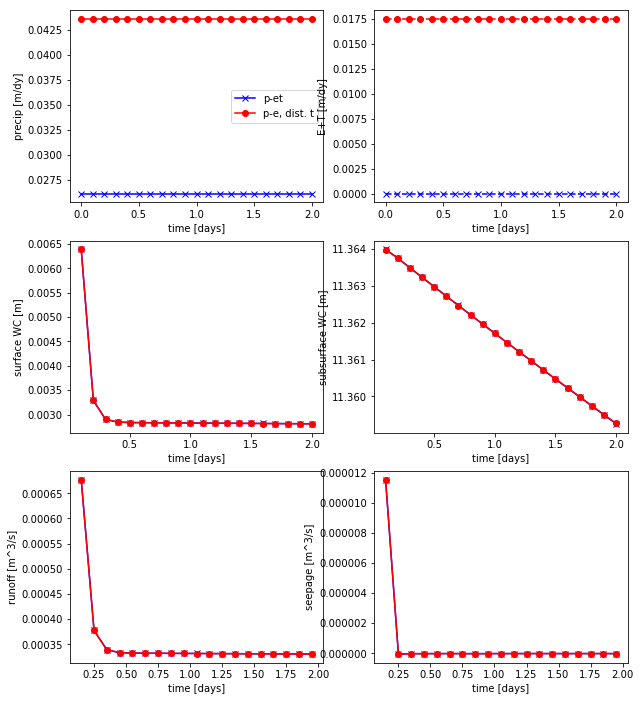

In [2]:
axs = mass_balance.get_axs()

names_to_update = dict(rain="surface-mass_source.cell.0")

# plot the P - ET case
sim = mass_balance.MassBalanceFromVis('p_minus_et.regression.gold', names=names_to_update)
mass_balance.plot(sim, axs, 'b', 'x', "p-et", skip_first=True)

# plot the distributed T case
sim = mass_balance.MassBalanceFromVis('p_minus_e_and_t.regression.gold', names=names_to_update)
mass_balance.plot(sim, axs, 'r', 'o', "p-e, dist. t", skip_first=True)

mass_balance.decorate(axs)
mass_balance.legend(axs)
plt.show()
